# Specifying Multivariate Effect Size

In basic statistics, **Cohen’s d′** tells you how far apart two class means sit in units of the data’s standard deviation:

$$
d' = \frac{\mu_{1} - \mu_{2}}{\sigma}
$$

In a **multivariate** setting—when you have many channels or features—the same intuition holds, but now “distance” depends not only on the raw mean difference and noise level, but also on:

- **How many features** carry the signal  
- **How noisy or correlated** those features are  
- **How the signal is spatially distributed** (uniformly across channels or concentrated in a subset)  

Our simulator takes your requested $d'$ and **automatically boosts or scales down** the raw amplitude of the injected pattern so that, no matter what noise level, covariance structure, or channel count you choose, the true multivariate Cohen’s $d'$ equals what you asked for—and a Bayes-optimal classifier would achieve the corresponding theoretical accuracy: 

$$\Phi(d'/2)$$


## Trials per subject

It’s well known that **more trials** generally improve decoding accuracy—but only **up to a point**.  For any fixed effect size $d'$, there is a **ceiling** on accuracy (e.g. $d'=0.5$ → ~69 %). 

To illustrate this, we can simulate data with 20, 40, 80 or 160 trials per condition:

In [4]:
# Simulation parameters
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from multisim import Simulator
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from mne.decoding import SlidingEstimator, cross_val_multiscore
from scipy.ndimage import gaussian_filter1d
from mne.stats import permutation_cluster_1samp_test, bootstrap_confidence_interval
from scipy.stats import ttest_1samp

# Add descriptors:
cond_names = ["category", "attention"]
mapping = {
    "category": {1: "face", -1: "object"},
    "attention": {1: "attended", -1: "unattended"},
}

n_channels = 32  # EEG system with 32 electrodes
n_subjects = 20  # Recording from 20 subjects
noise_std = 1 / 8  # Variance of the data
ch_cov = None  # Assuming that the data of each sensor are independent
sfreq = 50  # Simulating data at 50Hz
tmin = -0.25
tmax = 1.0
t = np.arange(0, 1, 1 / sfreq)  # time vector (in seconds)
kernel = None
intersub_noise_std = 0

# Specifying the effects:
effects = [
    {"condition": 'category', "windows": [0.1, 0.2], "effect_size": 0.5}, 
    {"condition": 'attention', "windows": [0.3, 0.4], "effect_size": 0.5}
    ]  # Packaging them in a list to pass to the simulator class


Text(0.5, 1.0, 'Sensor space decoding')

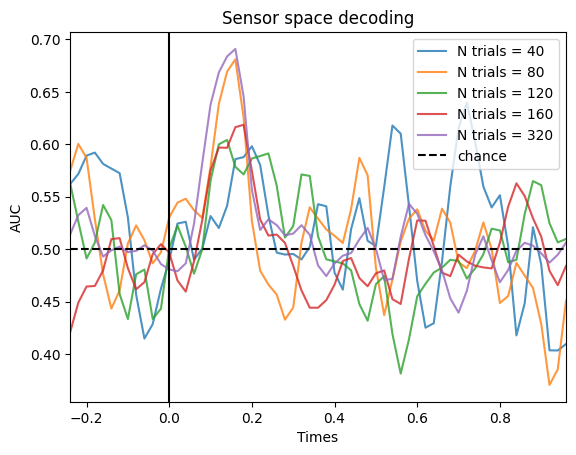

In [5]:
# Creating the design matrix of our 2 by two balanced design:
n_trials = [40, 80, 120, 160, 320]

# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

fig, ax = plt.subplots()
for n in n_trials:
    # Design matrix:
    X = pd.DataFrame(np.array([[1, 1, -1, -1] * int(n / 4), [1, -1] * int(n / 2)]).T, 
                     columns=cond_names)
    # Simulate the data:
    sims = Simulator(
        X,  # Design matrix
        noise_std,  # Observation noise
        n_channels,  # Number of channelss
        1,  # Number of subjects
        tmin,
        tmax,  # Start and end of epochs
        sfreq,  # Sampling frequency of the data
        effects,  # Effects
        ch_cov=ch_cov,  # Spatial covariance of the data
        kern=kernel,  # Temporal kernel,
        intersub_noise_std=intersub_noise_std,  # Intersubject variability
    )
    epochs = sims.export_to_mne(X=X.to_numpy()[:, :2], cond_names=cond_names, mapping=mapping)

    # Perform decoding:
    # Extract the data:
    data = epochs[0].get_data()
    # Decode faces vs. objects:
    cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])
    scores_category = np.mean(
        cross_val_multiscore(
            time_decod, data, cate_lbl, cv=5, n_jobs=None, verbose="WARNING"
        ),
        axis=0,
    )

    # Plot the results:
    ax.plot(
        epochs[0].times,
        gaussian_filter1d(scores_category, 1),
        label=f"N trials = {n}",
        alpha=0.8,
    )

ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

As we can see, increasing the number of trials only helps until a certain point. There is not so big of a difference between 160 and 320 trials. 

This has important implications. You may think that if there is a pattern in your data, if you have an absurdly hight amount of trial, you will be able to get the decoding accuracy to a 100%. That's not true, the max decoding accuracy is capped by the effect size. Even if you had 2000 trials, you wouldn't get higher in the previous simulation. Let's simulate that data set just to prove the point:

Text(0.5, 1.0, 'Sensor space decoding')

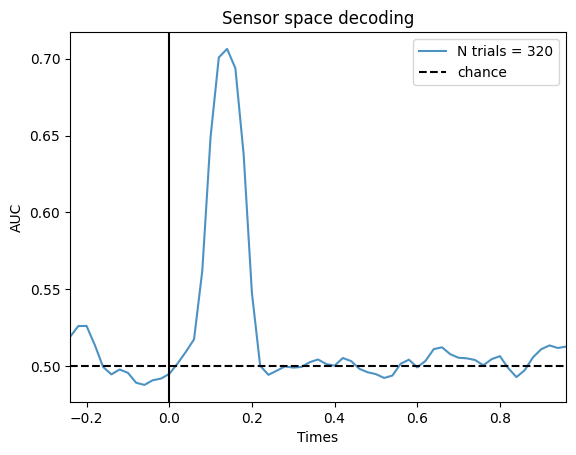

In [6]:
# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# Design matrix:
X = pd.DataFrame(np.array([[1, 1, -1, -1] * int(2000 / 4), [1, -1] * int(2000 / 2)]).T,
                 columns=cond_names)
# Simulate the data:
sims = Simulator(
    X,  # Design matrix
    noise_std,  # Observation noise
    n_channels,  # Number of channelss
    1,  # Number of subjects
    tmin,
    tmax,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    effects,  # effects
    ch_cov=ch_cov,  # Spatial covariance of the data
    kern=kernel,  # Temporal kernel,
    intersub_noise_std=intersub_noise_std,  # Intersubject variability
)
epochs = sims.export_to_mne(X=X.to_numpy()[:, :2], cond_names=cond_names, mapping=mapping)

# Perform decoding:
# Extract the data:
data = epochs[0].get_data()
# Decode faces vs. objects:
cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])
scores_category = np.mean(
    cross_val_multiscore(
        time_decod, data, cate_lbl, cv=5, n_jobs=None, verbose="WARNING"
    ),
    axis=0,
)

# Plot the results:
fig, ax = plt.subplots()
ax.plot(
    epochs[0].times,
    gaussian_filter1d(scores_category, 1),
    label=f"N trials = {n}",
    alpha=0.8,
)

ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

## Number of channels

While the number of trials has an impact on decoding accuracy, the number of channels shouldn't. That is because under the hood, we are normalizing the multivariate $d'$ by the number of features (and to be precise, the covariance matrix of the data). Let's simulate data set with different number of channels:

Text(0.5, 1.0, 'Sensor space decoding')

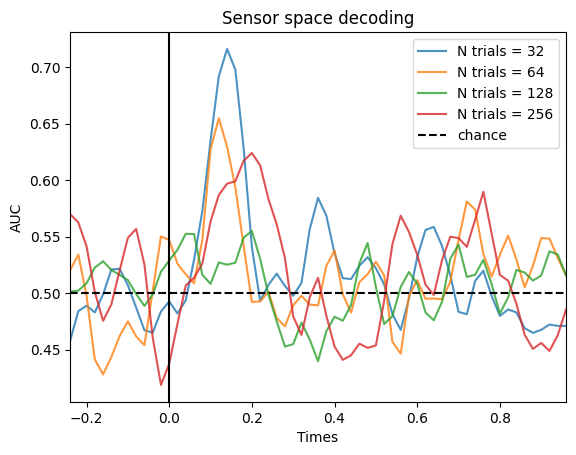

In [7]:
# Creating the design matrix of our 2 by two balanced design:
n_channels = [32, 64, 128, 256]

# Create the classifier:
clf = make_pipeline(StandardScaler(), SVC())

# Time resolved
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

fig, ax = plt.subplots()
for n in n_channels:
    # Design matrix:
    X = pd.DataFrame(np.array([[1, 1, -1, -1] * 40, [1, -1] * 80]).T,
                     columns=cond_names)
    # Simulate the data:
    sims = Simulator(
        X,  # Design matrix
        noise_std,  # Observation noise
        n,  # Number of channelss
        1,  # Number of subjects
        tmin,
        tmax,  # Start and end of epochs
        sfreq,  # Sampling frequency of the data
        effects, # Effects
        ch_cov=ch_cov,  # Spatial covariance of the data
        kern=kernel,  # Temporal kernel,
        intersub_noise_std=intersub_noise_std,  # Intersubject variability
    )
    epochs = sims.export_to_mne(X=X.to_numpy()[:, :2], cond_names=cond_names, mapping=mapping)

    # Perform decoding:
    # Extract the data:
    data = epochs[0].get_data()
    # Decode faces vs. objects:
    cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])
    scores_category = np.mean(
        cross_val_multiscore(
            time_decod, data, cate_lbl, cv=5, n_jobs=None, verbose="WARNING"
        ),
        axis=0,
    )

    # Plot the results:
    ax.plot(
        epochs[0].times,
        gaussian_filter1d(scores_category, 1),
        label=f"N trials = {n}",
        alpha=0.8,
    )

ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

Surprisingly, the decoding accuracy decreases with increased number of channels, which shouldn't happen based on our normalization. However, this behavior is expected. When we increase the number of features, we need to decrease the magnitude of the activation in each channel that are part of the pattern to yield a similar theoretical effect size. If we kept the magnitude the same, we would increase the effect size when increasing the number of channels. However, by decreasing the magnitude in each channel, we make it harder to discriminate from the noise of the signal, explaining the decrease in decoding accuracy. 

- **More channels** → the simulator spreads the same total signal across more sensors → **lower per-channel amplitude**  
- Lower per-channel SNR makes each feature harder to decode  
- As a result, accuracy **drops** with channel count unless you also increase trials or concentrate the signal in fewer channels  

This highlights a key trade-off: if your true brain signal lives in many sensors, you need **enough trials** (or stronger regularization/dimensionality reduction) to recover that tiny per-channel effect.


## Effect size, subjects & trials

When planning a study you must decide:

1. **How many trials per subject?**  
2. **How many subjects overall?**


There is an indirect trade off at play between these two, but one doesn't compensate for the other. 
- Too few trials per subject → you can’t reliably estimate decoding weights, and within-subject noise remains high.  
- Too few subjects → group-level statistics lack power, even if individual accuracies are above chance.

Crucially, **effect size** $d'$ sets a hard **upper limit** on decoding accuracy.  Even with thousands of trials, you cannot exceed $\Phi(d'/2)$.  And so for small effect sizes, you need many subjects to detect an effect. Let's simulate a data set with 8 subjects with an effect size of 0.2 to illustrate that point:

Using a threshold of 1.894579
stat_fun(H1): min=-1.9506476040779623 max=7.314992707693531
Running initial clustering …
Found 4 clusters


  0%|          | Permuting (exact test) : 0/255 [00:00<?,       ?it/s]

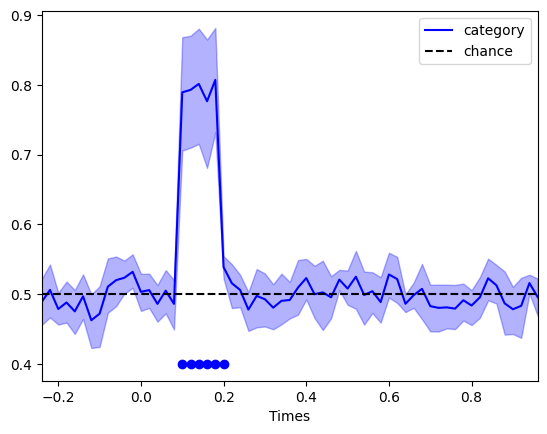

In [8]:
# Design matrix:
X = pd.DataFrame(np.array([[1, 1, -1, -1] * int(320 / 4), [1, -1] * int(320 / 2)]).T,
                 columns=cond_names)
# Specifying the effects:
effects = [
    {"condition": 'category', "windows": [0.1, 0.2], "effect_size": 0.1}, 
    {"condition": 'attention', "windows": [0.3, 0.4], "effect_size": 0.1}
    ]  # Packaging them in a list to pass to the simulator class

# Simulate the data:
sims = Simulator(
    X,  # Design matrix
    noise_std,  # Observation noise
    32,  # Number of channelss
    8,  # Number of subjects
    tmin,
    tmax,  # Start and end of epochs
    sfreq,  # Sampling frequency of the data
    effects,  # effects
    ch_cov=ch_cov,  # Spatial covariance of the data
    kern=kernel,  # Temporal kernel,
    intersub_noise_std=1 / 32,  # Intersubject variability
)
epochs = sims.export_to_mne(X=X.to_numpy()[:, :2], cond_names=cond_names, mapping=mapping)

# Extract labels:
cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])

# Loop through each subject:
scores_category = []
for epo in epochs:
    # Extract the data:
    data = epo.get_data()
    # Classification of category
    scores_category.append(
        np.mean(
            cross_val_multiscore(
                time_decod, data, cate_lbl, cv=5, n_jobs=None, verbose="WARNING"
            ),
            axis=0,
        )
    )

scores_category = np.array(scores_category)

# Group level statistics:
# Cluster based permutation test for the category:
T_obs, clusters, cluster_p_values, H0 = permutation_cluster_1samp_test(
    scores_category - 0.5,
    n_permutations=1024,
    tail=1,
    out_type="mask",
    verbose=True,
)
sig_mask_cate = np.zeros(len(epochs[0].times), dtype=bool)
for c, p_val in enumerate(cluster_p_values):
    if p_val < 0.05:
        sig_mask_cate[clusters[c]] = True
# Compute the confidence intervals:
ci_low_cate, ci_up_cate = bootstrap_confidence_interval(scores_category)

fig, ax = plt.subplots()
ax.plot(epochs[0].times, np.mean(scores_category, axis=0), label="category", color="b")
ax.fill_between(epochs[0].times, ci_low_cate, ci_up_cate, alpha=0.3, color="b")
ax.plot(
    epochs[0].times[sig_mask_cate],
    np.ones(np.sum(sig_mask_cate)) * 0.4,
    marker="o",
    linestyle="None",
    color="b",
)
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlim([epochs[0].times[0], epochs[0].times[-1]])
ax.set_xlabel("Times")
ax.legend()
plt.show()

Crucially, you should decide on the number of trials per subject to make sure you approach the ceiling decoding accuracy based on your effect size, and you should select the number of subjects to be able to detect an effect of that magnitude in your sample. 


## Putting it all together
To see how all these things play together, we will illustrate how to modulate number of subjects and trials at a given effect size (0.2) to show our toolbox can be applied to determine the optimal experimental design:

Text(0, 0.5, 'Number of subjects')

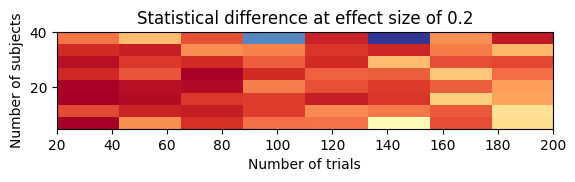

In [ ]:
n_trials = [20, 40, 80, 120, 140, 160, 180, 200]
n_subjects = [5, 10, 15, 20, 25, 30, 35, 40]

# Specifying the effects:
effects = [
    {"condition": 'category', "windows": [0.1, 0.2], "effect_size": 0.2}, 
    {"condition": 'attention', "windows": [0.3, 0.4], "effect_size": 0.2}
    ]  # Packaging them in a list to pass to the simulator class


tstat = np.zeros((len(n_subjects), len(n_trials)))
for i_s, ns in enumerate(n_subjects):
    for i_t, nt in enumerate(n_trials):
        # Design matrix:
        X = pd.DataFrame(np.array([[1, 1, -1, -1] * int(nt / 4), [1, -1] * int(nt / 2)]).T,
                         columns=cond_names)
        # Simulate the data:
        sims = Simulator(
            X,  # Design matrix
            noise_std,  # Observation noise
            32,  # Number of channelss
            ns,  # Number of subjects
            tmin,
            tmax,  # Start and end of epochs
            sfreq,  # Sampling frequency of the data
            effects,  # effects
            ch_cov=ch_cov,  # Spatial covariance of the data
            kern=kernel,  # Temporal kernel,
            intersub_noise_std=intersub_noise_std,  # Intersubject variability
        )
        epochs = sims.export_to_mne(X=X.to_numpy()[:, :2], cond_names=cond_names, mapping=mapping)

        # Extract labels:
        cate_lbl = np.array([mapping["category"][val] for val in X.to_numpy()[:, 0]])

        # Loop through each subject:
        scores_category = []
        for epo in epochs:
            # Extract the data:
            data = epo.get_data()
            # Classification of category
            scores_category.append(
                np.mean(
                    cross_val_multiscore(
                        time_decod, data, cate_lbl, cv=5, n_jobs=None, verbose="WARNING"
                    ),
                    axis=0,
                )
            )
        scores_category = np.array(scores_category)

        tstat[i_s, i_t] = np.max(ttest_1samp(scores_category, 0.5).statistic)

fig, ax = plt.subplots()
ax.imshow(
    tstat,
    aspect="auto",
    cmap="RdYlBu",
    extent=[n_trials[0], n_trials[-1], n_subjects[0], n_subjects[-1]],
)
ax.set_title("Statistical difference at effect size of 0.2")
ax.set_xlabel("Number of trials")
ax.set_ylabel("Number of subjects")

Text(0, 0.5, 'Number of subjects')

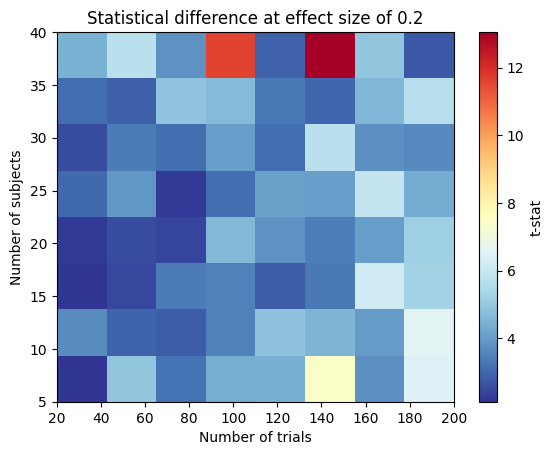

In [10]:
fig, ax = plt.subplots()
im = ax.imshow(
    tstat,
    aspect="auto",
    cmap="RdYlBu_r",
    extent=[n_trials[0], n_trials[-1], n_subjects[0], n_subjects[-1]],
)
cb = plt.colorbar(im, label="t-stat")
ax.set_title("Statistical difference at effect size of 0.2")
ax.set_xlabel("Number of trials")
ax.set_ylabel("Number of subjects")

## Conclusion and Practical Recommendations

The toy examples above highlight how **effect size**, **trials per subject**, and **number of subjects** jointly determine your ability to detect a multivariate pattern:

- A larger effect size $d'$ raises the theoretical accuracy ceiling.  
- More trials reduce the variability of your within-subject decoder and help you approach that ceiling.  
- More subjects reduce the uncertainty of the group-level mean and increase statistical power.

Importantly, these illustrations assumed **no between-subject variability**, an arbitrary noise level, and statistically independent channels. Real EEG/MEG data exhibit spatial correlations, nonstationary noise, and individual differences that will shift the precise numbers.

Use these simulations as **guiding examples**, not rigid rules. Tailor the parameters—noise level, spatial covariance, effect size, trial counts, subject counts—to match your planned experiment. By exploring your specific design _in silico_, you can make **principled decisions** about how many trials and participants you truly need to achieve reliable decoding at your desired effect size.

Our toolbox makes these trade-offs transparent and interactive, so you can optimize your study design before collecting a single real data point.

Below we provide more information on the mathematics of the effect-size calculations. It gets a bit technical, so feel free to skip these details if you like.

## Mathematical formulation of effect sizes (advanced)

In our simulation, we wish to inject a multivariate effect with a particular effect size. An effect size is often times computed using a Cohen $d'$, which computes the distance between two distribution:

$$d' = \frac{\mu_1 - \mu_2}{\sigma}$$

The Mahalanobis distance is a multivariate generalization of a Cohen $d'$. In our simulation, we inject a mean-difference vector $\Delta\mu = av$ into our multivariate data so that the Mahalanobis distance between the two class centroids equals the user’s requested effect size $d'$.  

The Mahalanobis distance is defined as:
$$d' = D_{M}(\mu_{1},\mu_{2}; \Sigma) = \sqrt{(\mu_{1}-\mu_{2})^{T}(\Sigma)^{-1}(\mu_{1}-\mu_{2})}$$

Where: 
- $\mu_{1}$ is the mean of the first condition
- $\mu_{2}$ is the mean of the second condition
- $\Sigma$ is the covariance matrix

Importantly, in our simulation, the channel covariance matrix gets multiplied by the channel level noise, so we have:

$Cov = \sigma^2\Sigma$

So the formulae for the d' is:

$$d' = D_{M}(\mu_{1},\mu_{2}; \sigma^2\Sigma) = \sqrt{(\mu_{1}-\mu_{2})^{T}(\sigma^2\Sigma)^{-1}(\mu_{1}-\mu_{2})}$$

### Injecting a scaled pattern

We wish to express the difference between the centroid of the two classes as a spatial pattern that we multiply by a constant, such that we can modulate the constant to control the effect size of the difference between both conditions. So we set:

$$\mu_{1}-\mu_{2}=av$$

where  
- $v$ is the spatial pattern (unit-norm across channels),  
- $a$ is a scalar amplitude to solve for.  

We can now subsitute $\mu_{1}-\mu_{2}$ by $av$:
$$
d'
=\sqrt{(av)^{T}(\sigma^{2}\Sigma)^{-1}(av)}
=\frac{a}{\sigma}\sqrt{v^{T}\Sigma^{-1}v}.
$$

### Solving for the amplitude $a$

We need to find the $a$ value, which is a scalar we can multiply our $\beta$ with, given the effect size $d'$, the channels noise $\sigma^2$ as well as the covariance matrix of our channels $\Sigma$. So we can solve the equation as follows: 
$$
a
= d'\sigma
    \Big/\sqrt{v^{T}\Sigma^{-1}v}.
$$

- If $\Sigma=I$ and $v$ is uniform, $\sqrt{v^{T}v}=\sqrt{n_{\rm channels}}$, so $a=d'\sigma/\sqrt{n}$.  
- For any other covariance, $\Sigma^{-1}$ automatically down-weights correlated or noisy channels.

Once $a$ is set, adding $\Delta\mu=av$ in your chosen time window guarantees a multivariate Cohen’s $d'=d'$, and thus a theoretical decoding accuracy of $\Phi(d'/2)$.  
